# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,roc_curve
import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)

Чтение данных

In [2]:
df = pd.read_csv('/datasets/Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Выведим последние пять строк

In [3]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,NaN,130142.79,1,1,0,38190.78,0


Столбец *CustomerId* назначаем индексом, удаляем столбцы *RowNumber* и *Surname* так как они не несут полезной информации

In [4]:
df.set_index('CustomerId',inplace=True)
df.drop(['RowNumber','Surname'],axis=1,inplace=True)

Выведим общую информацию

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


Имеются 909 незаполненных значений в стобце *Tenure*

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,9091.0,4.997690,2.894723,0.00,2.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


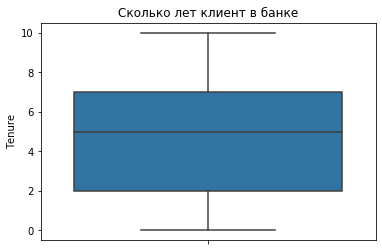

In [7]:
sns.boxplot(y='Tenure',data=df)
plt.title('Сколько лет клиент в банке');

Заполним пропуски медианной

In [8]:
df['Tenure'].fillna(df['Tenure'].median(),inplace=True)

Применим на категориальные столбцы метод прямого кодирования

In [9]:
df_ohe = pd.get_dummies(df,drop_first=True)
df_ohe.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,,
15634602,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
15647311,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
15619304,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
15701354,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
15737888,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


Отделим признаки и целевой признак

In [10]:
target = df_ohe['Exited']
features = df_ohe.drop('Exited', axis=1)

Разбиваем выборку на обучающую,валидационную,тестовую(60/20/20)

In [11]:
features_train,features_test,target_train,target_test = train_test_split(features,target, test_size=0.2, random_state=42,stratify=target)
features_train,features_valid,target_train,target_valid = train_test_split(features_train,target_train, test_size=0.25, random_state=42,stratify=target_train)

In [12]:
print('Кол-во записей на обучающей выборке',features_train.shape[0])
print('Кол-во записей на валидационной выборке',features_valid.shape[0])
print('Кол-во записей на тестовой выборке',features_test.shape[0])

Кол-во записей на обучающей выборке 6000
Кол-во записей на валидационной выборке 2000
Кол-во записей на тестовой выборке 2000


Числовые столбцы стандартезируем при помощи StandardScaler

In [13]:
numeric = ['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']
scaler = StandardScaler()

In [14]:
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [15]:
features_valid

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
CustomerId,,,,,,,,,,,
15745826,-2.132740,-0.186968,-0.720138,-1.240550,0.797297,1,1,1.406469,0,0,1
15613673,0.247290,-1.045643,1.439916,-1.240550,-0.913029,1,0,0.605094,0,0,1
15806467,-0.859941,0.099256,-1.440156,0.353591,-0.913029,0,0,0.613649,1,0,1
15805112,-0.756462,-0.091560,0.719898,0.080254,-0.913029,1,0,-1.579223,0,0,1
15753840,-1.315251,-0.664010,0.359889,-1.240550,-0.913029,1,1,0.583287,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
15665053,-0.156280,1.244156,-0.360129,0.546300,-0.913029,0,1,-1.161273,0,1,1
15606133,-0.239064,0.290073,0.719898,-1.240550,0.797297,0,1,1.283482,0,1,1
15660809,2.058183,-1.045643,-0.360129,-1.240550,0.797297,1,1,-1.519653,0,0,1


Объединим выборки обучающие и валидационную для GridSearchCV так как там используется кросс-валидация

In [15]:
features_train_cv = features_train.append(features_valid)
target_train_cv = target_train.append(target_valid)

### Вывод
Подготовили данные.Заполнили пропуски в столбце *Tenure*,категориальные столбцы преобразовали в числовые при помощи One-Hot Encoding,разделили данные на обучающую и тестовую, числовые столбцы стандартизировали StandardScaler.

## Исследование задачи

### Баланс классов

In [16]:
def class_ratio(df,title='Баланс классов'):
    df.value_counts(normalize=True).plot(kind='bar')
    plt.title(title);

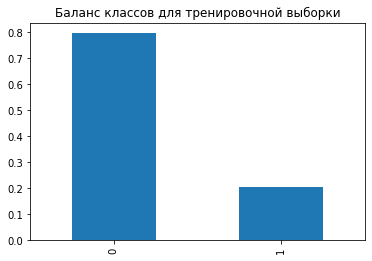

In [17]:
class_ratio(target_train,'Баланс классов для тренировочной выборки')

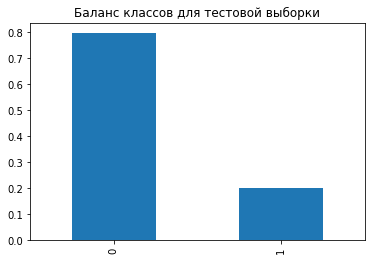

In [18]:
class_ratio(target_test,'Баланс классов для тестовой выборки')

Баланс классов для тренировочной и тестовой выборки сохранен при разделение, 80/20 баланс классов

### Подборка Гиперпараметров без учета баланса классов

Напишем функцию которая будет принимать на вход train и target выборку,параметры, и при помощи GridSearchCV подберет лучшие из них

In [19]:
def grid_cv_result(features_train,target_train,params):
    scores = []
    for model_name, mp in params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=-1,scoring='f1')
        clf.fit(features_train, target_train)   
        scores.append({
            'model': model_name,
            'best_f1_score': clf.best_score_,
            'best_params': clf.best_params_
        })
    result = pd.DataFrame(scores,columns=['model','best_f1_score','best_params'])
    return result

Параметры моделей для GridSearchCV

In [20]:
model_params = {
        'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params' : {
            'solver':['liblinear','lbfgs','newton-cg','sag'],
            'C': [1000,100,10,1,0.1,0.001]
            
        }  
    },
    
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params' : {
            'max_depth': range(1,20), # высота дерева от 1 до 10
            'min_samples_split':range(2,20,2),# минимальное число объектов для разделения
            'criterion':['gini','entropy']
            
        }  
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params' : {
            'n_estimators': range(20,30),#число деревьев
            'max_depth': range(1,20),# высота деревьев
            'min_samples_split':range(2,10,2)# минимальное число объектов для разделения
            
        }
    } 
}

Результаты лучшие параметры и f1_score

In [21]:
grid = grid_cv_result(features_train_cv,target_train_cv,model_params)
grid

,model,best_f1_score,best_params
0,LogisticRegression,0.318340,"{'C': 1000, 'solver': 'liblinear'}"
1,DecisionTree,0.573919,"{'criterion': 'entropy', 'max_depth': 8, 'min_samples_split': 18}"
2,RandomForest,0.585740,"{'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 25}"


### Вывод 
Баланс классов 80/20, построили модели без учета баланса класса.При помощи перебора параметров с помощью GridSearchCV f1_score у RandomForest 58%, DecisionTree	57% хуже всего LogisticRegression 31% 

## Борьба с дисбалансом

### Взвешивание классов

Параметры моделей для GridSearchCV

In [22]:
model_params_balanced = {
      'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params' : {
            'solver':['liblinear','lbfgs','newton-cg','sag'],
            'C': [1000,100,10,1,0.1,0.001],
            'class_weight':['balanced']
            
        }  
    },
    
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params' : {
            'max_depth': range(1,20), # высота дерева от 1 до 10
            'min_samples_split':range(2,20,2),# минимальное число объектов для разделения
            'criterion':['gini','entropy'],
            'class_weight':['balanced']
        }  
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params' : {
            'n_estimators': range(20,30),#число деревьев
            'max_depth': range(1,20),# высота деревьев
            'min_samples_split':range(2,10,2),# минимальное число объектов для разделения
            'class_weight':['balanced']
        }
    } 
}

In [23]:
grid_balanced = grid_cv_result(features_train_cv,target_train_cv,model_params_balanced)
grid_balanced

,model,best_f1_score,best_params
0,LogisticRegression,0.499275,"{'C': 0.001, 'class_weight': 'balanced', 'solver': 'liblinear'}"
1,DecisionTree,0.573431,"{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 18}"
2,RandomForest,0.621990,"{'class_weight': 'balanced', 'max_depth': 8, 'min_samples_split': 6, 'n_estimators': 25}"


### Вывод
При помощи параметра **class_weight** - *balanced*, увеличили f1_score для RandomForest 62% и LogisticRegression 49%, DecisionTree остался при своих 57%

### Увеличение выборки

Напишем функцию которая увеличит класс '1',что бы баланс был одинаковым

In [24]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled


In [25]:
features_upsampled, target_upsampled = upsample(features_train,target_train,4)

Посмотрим корректно ли отработала функция

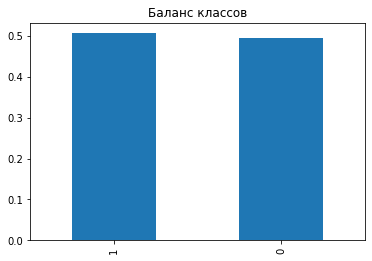

In [26]:
class_ratio(target_upsampled)

Баланс классов примерно одинаков

In [27]:
model_params_upsample = {
        'LogisticRegression': {
        'model': LogisticRegression(random_state=42),
        'params' : {
            'solver':['liblinear','lbfgs','newton-cg','sag'],
            'C': [1000,100,10,1,0.1,0.001]
            
        }  
    },
    
    'DecisionTree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params' : {
            'max_depth': range(1,20), # высота дерева от 1 до 10
            'min_samples_split':range(2,20,2),# минимальное число объектов для разделения
            'criterion':['gini','entropy']
            
        }  
    },
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params' : {
            'n_estimators': range(20,30),#число деревьев
            'max_depth': range(1,20),# высота деревьев
            'min_samples_split':range(2,10,2)# минимальное число объектов для разделения
            
        }
    } 
}

In [28]:
def grid_cv_result_valid(features_train,target_train,params):
    scores = []
    for model_name, mp in params.items():
        clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=-1,scoring='f1')
        clf.fit(features_train, target_train)
        pred = clf.predict(features_valid)
        f1_valid = f1_score(pred,target_valid)
        scores.append({
            'model': model_name,
            'valid_f1_score': f1_valid,
            'best_params': clf.best_params_
        })
    result = pd.DataFrame(scores,columns=['model','valid_f1_score','best_params'])
    return result

In [29]:
grid_upsample = grid_cv_result_valid(features_upsampled,target_upsampled,model_params_upsample)
grid_upsample

,model,valid_f1_score,best_params
0,LogisticRegression,0.493783,"{'C': 0.001, 'solver': 'lbfgs'}"
1,DecisionTree,0.526690,"{'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 2}"
2,RandomForest,0.595687,"{'max_depth': 18, 'min_samples_split': 2, 'n_estimators': 28}"


## Тестирование модели

Список моделей

In [30]:
lr_model = LogisticRegression(random_state=42)
tree_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
models = [lr_model,tree_model,rf_model]

Напишем функцию которая будет на вход принимать список моделей,параметры,обучающую выборку.Возвращать f1_score на тестовой выборке,и auc_roc_score

In [31]:
def set_param_fit(models,param,features_train,target_train):
    i=0
    scores = []
    model_name = ['LogisticRegression','DecisionTree','RandomForest']
    for  model in models:
        best_param = param['best_params'][i]
        model.set_params(**best_param)
        model.fit(features_train, target_train)
        predictions = model.predict(features_test)
        score = f1_score(predictions,target_test)
        proba_test = model.predict_proba(features_test)
        proba_one_test = proba_test[:, 1]
        auc_roc = roc_auc_score(target_test, proba_one_test)
        scores.append({
        'model': model_name[i],
        'best_f1_score_test':score,
        'roc_auc_score': auc_roc
        })
        i+=1
        result = pd.DataFrame(scores,columns=['model','best_f1_score_test','roc_auc_score'])
    return result

In [55]:
def draw_roc_curve(models,param):
    i=0
    model_name = ['LogisticRegression','DecisionTree','RandomForest']
    for  model in models:
        best_param = param['best_params'][i]
        model.set_params(**best_param)
        model.fit(features_train, target_train)
        proba_test = model.predict_proba(features_test)
        proba_one_test = proba_test[:, 1]
        auc_roc = roc_auc_score(target_test, proba_one_test)
        fpr, tpr, thresholds = roc_curve(target_test,proba_one_test)
        plt.figure()
        plt.grid(b=True, which='major', color='#666666', linestyle='-')
        plt.plot(fpr,tpr)
        plt.plot([0, 1], [0, 1], linestyle='--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC-кривая ' + model_name[i])
        plt.text(0.6, 0.45, 'ROC-AUC: ' +str(round(auc_roc,2)), dict(size=15))
        plt.show()
        i+=1
        

**ROC-кривая на тестовом наборе без баланса классов**

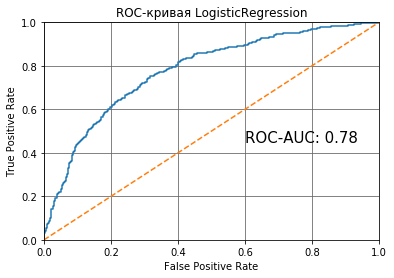

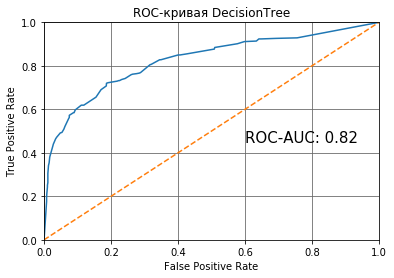

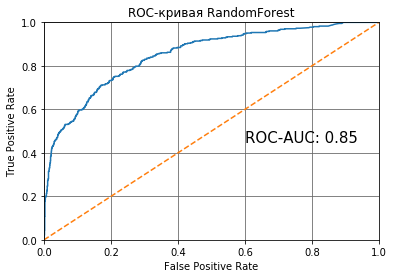

In [56]:
draw_roc_curve(models,grid)

**f1_score на тестовом наборе без баланса классов**

In [34]:
set_param_fit(models,grid,features_train_cv,target_train_cv)

,model,best_f1_score_test,roc_auc_score
0,LogisticRegression,0.290503,0.774889
1,DecisionTree,0.584435,0.832731
2,RandomForest,0.579666,0.850919


**ROC-кривая на тестовом наборе с взвешиванием классов**

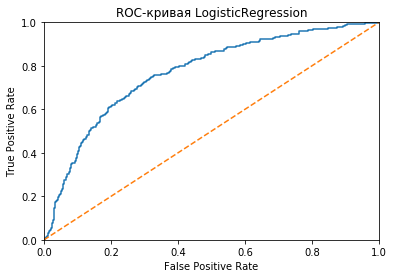

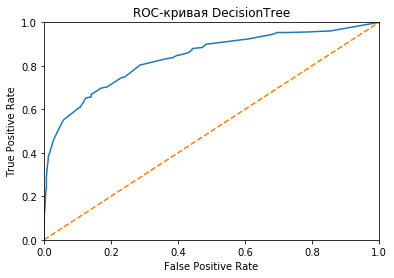

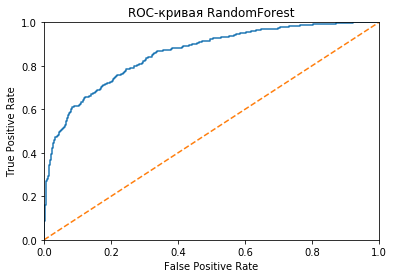

In [35]:
draw_roc_curve(models,grid_balanced)

**f1_score на тестовом наборе с взвешиванием классов**

In [36]:
set_param_fit(models,grid_balanced,features_train_cv,target_train_cv)

,model,best_f1_score_test,roc_auc_score
0,LogisticRegression,0.504505,0.770550
1,DecisionTree,0.569014,0.830924
2,RandomForest,0.620838,0.862979


**ROC-кривая на тестовом наборе с увеличением выборки**

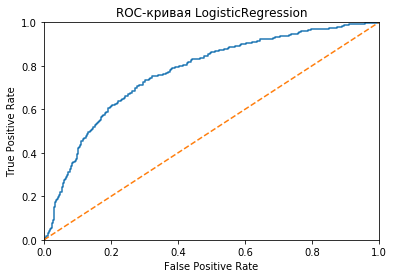

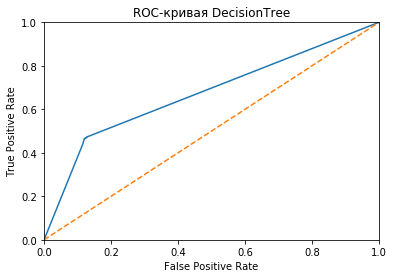

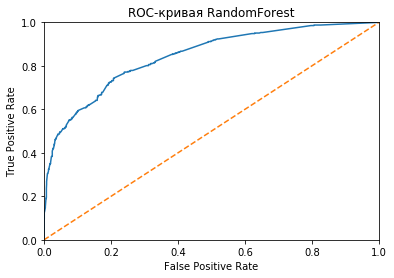

In [37]:
draw_roc_curve(models,grid_upsample)

**f1_score на тестовом наборе с увеличением выборки**

In [38]:
set_param_fit(models,grid_upsample,features_upsampled,target_upsampled)

,model,best_f1_score_test,roc_auc_score
0,LogisticRegression,0.509317,0.772625
1,DecisionTree,0.493252,0.683382
2,RandomForest,0.574099,0.849941


### Вывод
Модель которой удалось достичь F1-меры выше 0,59 Случайный лес с взвешиванием классов показал самый высокий f1_score в 0,62 и roc_auc_score в 0,85